In [1287]:
import pandas as pd
import numpy as np
from pathlib import Path

import opinionated
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("opinionated_fsc")
import colormaps as cmaps 

import module
import importlib
import warnings

try:
    importlib.reload(module)  # reload module
except NameError:
    pass

In [1288]:
path = Path.cwd().parents[0] / "output/vote_result.xlsx"
df = pd.read_excel(path)

# 1. Apakah Gabung ke Partai Besar Lebih Baik dari Gabung ke Partai Kecil?

Dalam kasus ini, **partai besar** akan kita artikan sebagai partai yang total suara partainya di atas median total suara dari seluruh partai. 
Sebaliknya, **partai kecil** akan kita artikan sebagai partai yang total suara partainya nya di bawah median total suara dari seluruh partai. 

Kenapa kita memakai median, bukan mean/rata-rata? Karena distribusi suara terhadap partai sangat tidak seimbang. Partai-partai yang paling besar mendapat jauh lebih suara sibanding partai lain. Karena itu, kita memilih median.

Berikut adalah tabel partai, total vote beserta ukurannya.

In [1289]:
data_partai = (df
    .loc[:, ["dapil_no", "partai", "partai_vote"]]
    .drop_duplicates()
    .groupby("partai")
    .agg(total_suara_partai=("partai_vote", "sum"))
    .sort_values("total_suara_partai", ascending=False)
    .reset_index()
    .assign(
        ukuran_partai=lambda df_: np.where(
            (df_["total_suara_partai"] < df_["total_suara_partai"].median()),
            "Partai Kecil",
            "Partai Besar",
        )
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
)
data_partai

,Partai,Total Suara Partai,Ukuran Partai
0,PDIP,568094,Partai Besar
1,Gerindra,283887,Partai Besar
2,PKS,273862,Partai Besar
3,PSI,185166,Partai Besar
4,Demokrat,108641,Partai Besar
5,PKB,92451,Partai Besar
6,PAN,88689,Partai Besar
7,Nasdem,82202,Partai Besar
8,Golkar,76441,Partai Kecil
9,Perindo,72813,Partai Kecil


Selain itu, kita perlu mencari jumlah calon per partai dan jumlah calon terpilih per partai.

In [1290]:
data_partai_full = (df
    .groupby("partai")
    .agg(
        jumlah_calon=("nama", "size"),
        jumlah_terpilih=("terpilih", "sum"),
        total_suara_calon=("vote", "sum"),
    )
    .reset_index()
    .assign(
        persentase_terpilih=lambda df_: df_["jumlah_terpilih"]
        .div(df_["jumlah_calon"])
        .mul(100)
        .round(1)
    )
    .rename(columns=lambda c: c.replace("_", " ").title())
    .merge(right=data_partai, on="Partai")
    .sort_values("Total Suara Partai", ignore_index=True, ascending=False)
    .loc[
        :,
        [
            "Partai",
            "Jumlah Calon",
            "Jumlah Terpilih",
            "Persentase Terpilih",
            "Total Suara Calon",
            "Total Suara Partai",
            "Ukuran Partai",
        ],
    ]
)
data_partai_full

,Partai,Jumlah Calon,Jumlah Terpilih,Persentase Terpilih,Total Suara Calon,Total Suara Partai,Ukuran Partai
0,PDIP,106,25,23.6,768230,568094,Partai Besar
1,Gerindra,106,19,17.9,651906,283887,Partai Besar
2,PKS,106,16,15.1,643143,273862,Partai Besar
3,PSI,106,8,7.5,219342,185166,Partai Besar
4,Demokrat,106,10,9.4,277793,108641,Partai Besar
5,PKB,106,5,4.7,215761,92451,Partai Besar
6,PAN,106,9,8.5,287193,88689,Partai Besar
7,Nasdem,106,7,6.6,227588,82202,Partai Besar
8,Golkar,106,6,5.7,223805,76441,Partai Kecil
9,Perindo,106,0,0.0,95483,72813,Partai Kecil


Dari tabel ini, bisa kita lihat trend yang jelas: 
1. Suara terhadap partai berbanding lurus dengan suara terhadap calon.
2. Semakin besar partai, semakin besar pula persentase calon dari partai tersebut yang terpilih.
3. Partai kecil hanya menyumbang 7 calon terpilih dari total 106 calon terpilih. Jumlah yang sangat kecil.

Mari kita lihat lebih dekat trend trend diatas.

## 1.1 Suara terhadap partai berbanding lurus dengan suara terhadap calon

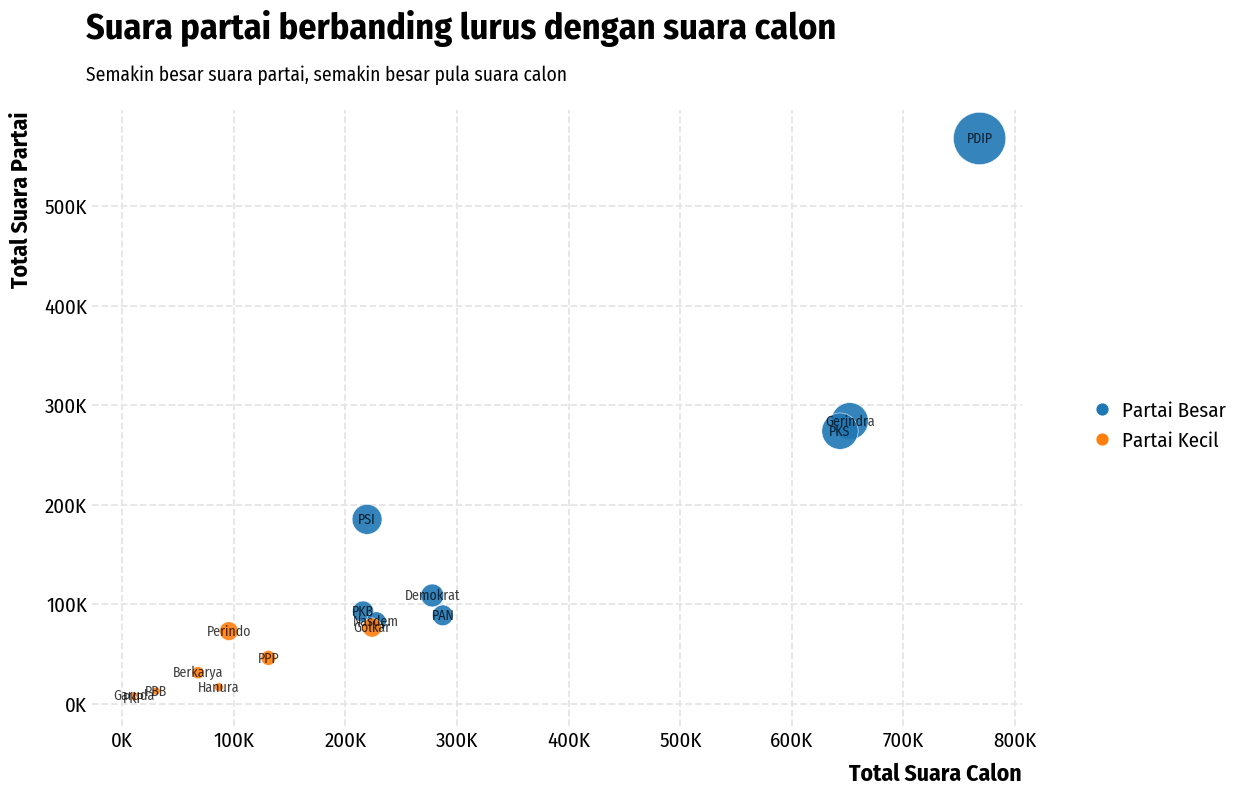

In [1291]:
x = "Total Suara Calon"
y = "Total Suara Partai"
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    x=x,
    y=y,
    hue="Ukuran Partai",
    data=data_partai_full,
    alpha=0.9,
    s=data_partai_full["Total Suara Partai"] / 400,
)
opinionated.add_legend(title="")
opinionated.set_title_and_suptitle(
    "Suara partai berbanding lurus dengan suara calon",
    "Semakin besar suara partai, semakin besar pula suara calon",
)
module.label_point(
    data_partai_full[x], data_partai_full[y], data_partai_full["Partai"], plt.gca()
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if max(data_partai_full[x]) >= 1000: 
        xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
        ax.set_xticklabels(xlabels)
    if max(data_partai_full[y]) >= 1000: 
        ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)

plt.show()

## 1.2 Semakin besar partai, semakin besar pula persentase calon dari partai tersebut yang terpilih

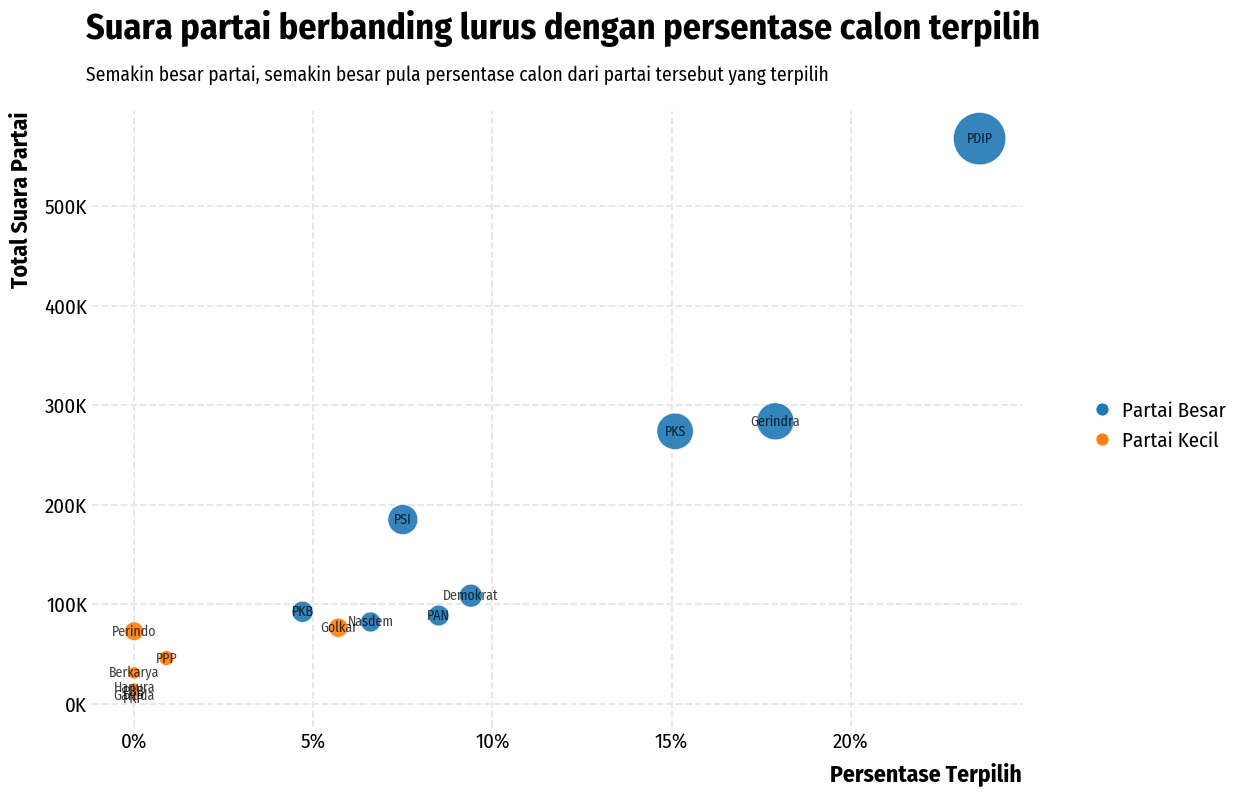

In [1292]:
x = "Persentase Terpilih"
y = "Total Suara Partai"
f, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    x=x,
    y=y,
    hue="Ukuran Partai",
    data=data_partai_full,
    alpha=0.9,
    s=data_partai_full["Total Suara Partai"] / 400,
)
opinionated.add_legend(title="")
opinionated.set_title_and_suptitle(
    "Suara partai berbanding lurus dengan persentase calon terpilih",
    "Semakin besar partai, semakin besar pula persentase calon dari partai tersebut yang terpilih",
)
module.label_point(
    data_partai_full[x], data_partai_full[y], data_partai_full["Partai"], plt.gca()
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    if max(data_partai_full[x]) >= 1000: 
        xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
        ax.set_xticklabels(xlabels)
    if max(data_partai_full[x]) <= 100: 
        xlabels = ['{:,.0f}'.format(x) + '%' for x in ax.get_xticks()]
        ax.set_xticklabels(xlabels)
    if max(data_partai_full[y]) >= 1000: 
        ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
        ax.set_yticklabels(ylabels)

plt.show()

## 1.3 Partai kecil hanya menyumbang 7 calon terpilih dari total 106 calon terpilih

In [1293]:
data_partai_per_ukuran = (data_partai_full
    .groupby(["Ukuran Partai"])
    .agg(
        jumlah_terpilih=('Jumlah Terpilih', 'sum'),
        persentase_terpilih=('Persentase Terpilih', 'sum'),
    )
    .reset_index()
    .rename(columns=lambda c: c.replace("_", " ").title())
)
data_partai_per_ukuran

,Ukuran Partai,Jumlah Terpilih,Persentase Terpilih
0,Partai Besar,99,93.3
1,Partai Kecil,7,6.6


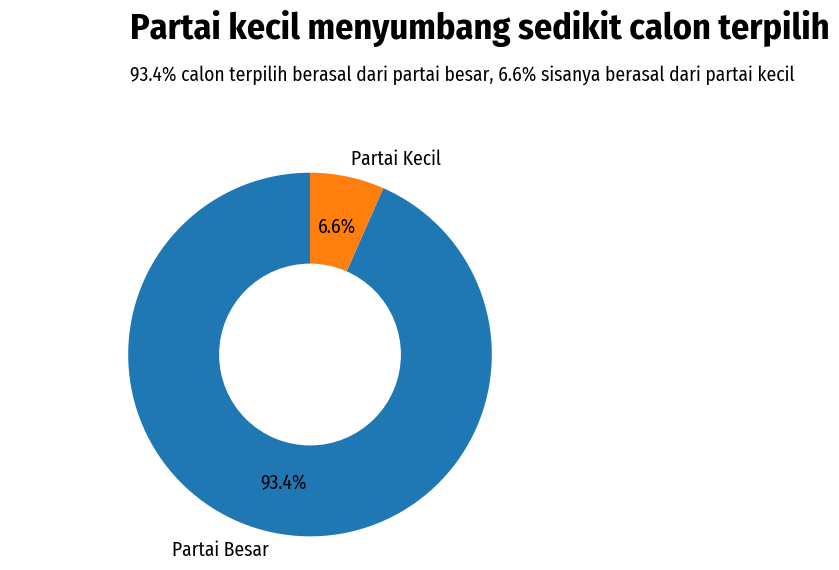

In [1312]:
module.create_donut(
    data_partai_per_ukuran["Persentase Terpilih"],
    data_partai_per_ukuran["Ukuran Partai"],
    "Partai kecil menyumbang sedikit calon terpilih",
    "93.4% calon terpilih berasal dari partai besar, 6.6% sisanya berasal dari partai kecil",
)

Dilihat dari perspektif lain, jika kita bergabung dengan partai kecil, kemungkinan kita terpilih hanya 0.91%, amat sangat kecil.

In [1321]:
(data_partai_full
    .groupby(["Ukuran Partai"])
    .agg(
        jumlah_calon=('Jumlah Calon', 'sum'), 
        jumlah_terpilih=('Jumlah Terpilih', 'sum'),
    )
    .assign(kemungkinan_terpilih_dalam_persen=lambda df_: (df_['jumlah_terpilih']
                                              .div(df_['jumlah_calon']))
                                              .mul(100)
                                              .round(2)
                                              )
    .reset_index()
    .rename(columns=lambda c: c.replace("_", " ").title())
)

,Ukuran Partai,Jumlah Calon,Jumlah Terpilih,Kemungkinan Terpilih Dalam Persen
0,Partai Besar,848,99,11.67
1,Partai Kecil,767,7,0.91


## Kesimpulan

**Bergabung dengan partai besar jauh lebih menguntungkan daripada bergabung dengan partai kecil**. Dengan bergabung dengan partai besar, calon hampir pasti akan mendapatkan jauh lebih banyak suara dibandingkan jika calon bergabung dengan partai kecil. Efek dari hal ini, kemungkinan calon terpilih akan naik. 

Salah satu alasan utama untuk ini adalah fanatisme pemilih dalam pemilihan umum. **Dalam konteks pemilihan umum, pengaruh partai jauh lebih dominan dibandingkan dengan pengaruh calon.** Dengan kata lain, masyarakat cenderung lebih "mengikuti partai" daripada "mengikuti calon."

Menurut temuan dari Survey Indikator Politik Indonesia dalam makalah berjudul "Efek Popularitas Calon Legislatif Terhadap Elektabilitas Partai Jelang Pemilu 2014":
> - Secara umum, **hasil akhir pemilu sangat ditentukan oleh kekuatan partai**. Para calon hanya sedikit pengaruhnya.
> - Hasil survei tahun 2013 ini konsisten dengan temuan survei tahun 2009. **Calon memiliki kontribusi terhadap suara partai, namun kontribusinya sangat kecil** bila dibandingkan kekuatan partai itu sendiri.
> - Para calon pada umumnya sangat bergantung pada kekuatan partai. **Sebagian besar calon legislatif menumpang popularitas partainya**.

[Referensi: Survey Indikator Politik Indonesia - Efek Popularitas Calon Legislatif Terhadap Elektabilitas Partai Jelang Pemilu 2014](https://www.indikator.co.id/uploads/20131014105703.20130730171101.INDIKATOR_Rilis_Survei_Efek_Calon_Terhadap_Partai.pdf)

# 2. Apakah Mungkin Seorang Calon Terpilih saat Calon tsb. Berasal dari Partai Kecil?

In [1324]:
data_partai_full.loc[data_partai_full["Ukuran Partai"] == "Partai Kecil"]

,Partai,Jumlah Calon,Jumlah Terpilih,Persentase Terpilih,Total Suara Calon,Total Suara Partai,Ukuran Partai
8,Golkar,106,6,5.7,223805,76441,Partai Kecil
9,Perindo,106,0,0.0,95483,72813,Partai Kecil
10,PPP,106,1,0.9,130948,45887,Partai Kecil
11,Berkarya,106,0,0.0,67833,31044,Partai Kecil
12,Hanura,106,0,0.0,86656,16417,Partai Kecil
13,PBB,106,0,0.0,30439,12513,Partai Kecil
14,Garuda,60,0,0.0,10688,8517,Partai Kecil
15,PKP,71,0,0.0,10635,5130,Partai Kecil


Hanya ada 7 calon terpilih yang berasal dari partai kecil: 
- 6 calon terpilih dari partai Golkar
- 1 calon terpilih dari partai PPP

Walaupun demikian, untuk partai Golkar, walaupun suara partai dibawah median, namun partai Golkar merupakan partai kecil dengan suara terbanyak. Jarak suara antara partai Golkar dengan partai besar terendah yaitu Nasdem hanya 5.761 suara, jumlah yang relatif kecil mengingat kedua partai ini masing-masing meraup sekitar 80.000 suara.

In [1332]:
(data_partai_full
    .loc[data_partai_full["Partai"].isin(['Nasdem', 'Golkar'])]
)

,Partai,Jumlah Calon,Jumlah Terpilih,Persentase Terpilih,Total Suara Calon,Total Suara Partai,Ukuran Partai
7,Nasdem,106,7,6.6,227588,82202,Partai Besar
8,Golkar,106,6,5.7,223805,76441,Partai Kecil


Karena itu, kita akan melihat case outlier yang sesungguhnya: 1 calon terpilih dari partai PPP.

## Case : 1 Calon Terpilih dari Partai PPP

In [1333]:
df.loc[(df['partai'] == 'PPP') & (df['terpilih'] == 1)]

,dapil_no,dapil_nama,no_urut,nama,vote,partai,partai_vote,terpilih
855,6,Jakarta Timur,1,"Matnoor Tindoan, S.H.",21553,PPP,6238,1


Menagapa 1 calon ini bisa terpilih? Mari kita lihat performa PPP di dapil nomor 6.

In [1338]:
(df
    .loc[(df['partai'] == 'PPP') & (df['dapil_no'] == 6)]
    .rename(columns=lambda c: c.title().replace("_", " "))
) 

,Dapil No,Dapil Nama,No Urut,Nama,Vote,Partai,Partai Vote,Terpilih
855,6,Jakarta Timur,1,"Matnoor Tindoan, S.H.",21553,PPP,6238,1
856,6,Jakarta Timur,2,Hj. Neneng Radhiah,1566,PPP,6238,0
857,6,Jakarta Timur,3,"Ahmad Guntur, S.E.",759,PPP,6238,0
858,6,Jakarta Timur,4,Aris Sandi Rosid,381,PPP,6238,0
859,6,Jakarta Timur,5,Mery Daryanti,179,PPP,6238,0
860,6,Jakarta Timur,6,Hj. Nurzaidah,597,PPP,6238,0
861,6,Jakarta Timur,7,Neni Sutisna,267,PPP,6238,0
862,6,Jakarta Timur,8,"Wardi, S.Ag., M.Si.",170,PPP,6238,0
863,6,Jakarta Timur,9,Junaedi,196,PPP,6238,0
864,6,Jakarta Timur,10,Muhammad Hatta,492,PPP,6238,0


Jika kita lihat dari performa PPP di dapil 6, calon terpilih atas nama Matnoor Tindoan, S.H. merupakan outlier, dalam artian calon ini outperform calon lain dari PPP dengan sangat jauh. Bisa kita lihat bahwa suara yang didapat calon ini adalah 21.553, sedangkan calon dengan suara terbanyak kedua, Hj. Neneng Radhiah, hanya mendapat 1.566 suara, 10x lebih kecil.

Dilihat dari sisi lain, suara yang didapatkan Matnoor Tindoan, S.H. merupakan 82% suara yang didapat calon PPP di dapil tersebut.

In [1339]:
(df
    .loc[(df["partai"] == "PPP") & (df["dapil_no"] == 6)]
    .assign(
        nama=lambda df_: np.where(
            df_["nama"] == "Matnoor Tindoan, S.H.",
            "Matnoor Tindoan, S.H.",
            "Calon Lain dari PPP di Dapil 6",
        )
    )
    .groupby("nama")
    .agg(vote=("vote", "sum"))
    .reset_index()
    .sort_values("vote", ascending=False)
    .assign(
        persentase_vote=lambda df_: df_["vote"].div(df_["vote"].sum()).mul(100).round(2)
    )
    .rename(columns=lambda c: c.title().replace("_", " "))
)

,Nama,Vote,Persentase Vote
1,"Matnoor Tindoan, S.H.",21553,82.39
0,Calon Lain dari PPP di Dapil 6,4607,17.61


Secara rata-rata, calon lain dari seluruh partai di dapil 6 hanya mendapatkan 2.376 suara, 10x lebih kecil dari suara yang didapatkan Matnoor Tindoan, S.H.

In [1350]:
(df
    .loc[(df["dapil_no"] == 6)]
    .assign(
        nama=lambda df_: np.where(
            df_["nama"] == "Matnoor Tindoan, S.H.",
            "Matnoor Tindoan, S.H.",
            "Calon lain dari seluruh partai di dapil 6",
        )
    )
    .groupby("nama")
    .agg(vote=("vote", "mean"))
    .astype(int)
    .reset_index()
    .sort_values("vote", ascending=False)
    .rename(columns=lambda c: c.title().replace("_", " "))
)

,Nama,Vote
1,"Matnoor Tindoan, S.H.",21553
0,Calon lain dari seluruh partai di dapil 6,2376


Bahkan, Matnoor Tindoan, S.H. merupakan calon dengan suara terbesar kedua di dapil 6, walaupun berasal dari partai kecil.

In [1353]:
(df
    .loc[(df['dapil_no'] == 6)]
    .sort_values('vote', ascending=False)
    .head(10)
    .drop(columns=['partai_vote', 'terpilih'])
    .rename(columns=lambda c: c.title().replace('_', ' '))
    .reset_index(drop=True)
)

,Dapil No,Dapil Nama,No Urut,Nama,Vote,Partai
0,6,Jakarta Timur,8,Hj. Umi Kulsum,27606,PKS
1,6,Jakarta Timur,1,"Matnoor Tindoan, S.H.",21553,PPP
2,6,Jakarta Timur,7,Drs. K.H. Muhammad Thamrin,16767,PKS
3,6,Jakarta Timur,1,H. Misan Samsuri,16573,Demokrat
4,6,Jakarta Timur,1,Syarif,15517,Gerindra
5,6,Jakarta Timur,1,H. Karyatin Subiyantoro,12572,PKS
6,6,Jakarta Timur,1,"Dr. Ir. H. Rasyidi H. Y., M.M., C.P.A., M.A.",11871,PDIP
7,6,Jakarta Timur,1,Panel Barus,10547,Nasdem
8,6,Jakarta Timur,1,"Dr. Muhammad Guntur, S.E., M.M.",10067,Hanura
9,6,Jakarta Timur,4,Bambang Kusumanto,9707,PAN


## Kesimpulan

Walapun ada case dimana calon dari partai kecil terpilih, kemungkinan terpilihnya calon dari partai kecil tetap sangat tipis.

Matnoor Tindoan, S.H. dapat terpilih walaupun berasal dari partai kecil karena secara individu, dia outperform seluruh calon lain di dapil 6 (kecuali Hj. Umi Kulsum). Sulit untuk mengetahui kenapa Matnoor bisa outperform calon lain hanya dari data ini, karena popularitas Matnoor Tindoan, S.H. berasal dari faktor eksternal. Namun, saya yakin bahwa salah satu faktor adalah fakta bahwa sebelumnya, Matnoor Tindoan, S.H. sudah 2x terpilih sebagai DPRD di dapil yang sama (https://www.rmoldkijakarta.id/akhirnya-ppp-raih-kursi-dprd-lewat-matnoor-tindoan). Hal ini mendandakan bahwa 
1. Matnoor sudah memiliki basis pendukung yang kuat di dapil 6.
2. Matnoor memiliki waktu selama 2 periode untuk memperkuat basis dukungannya di dapil 6.

# 3. Bagaimana Performa Partai di Tiap Dapil?

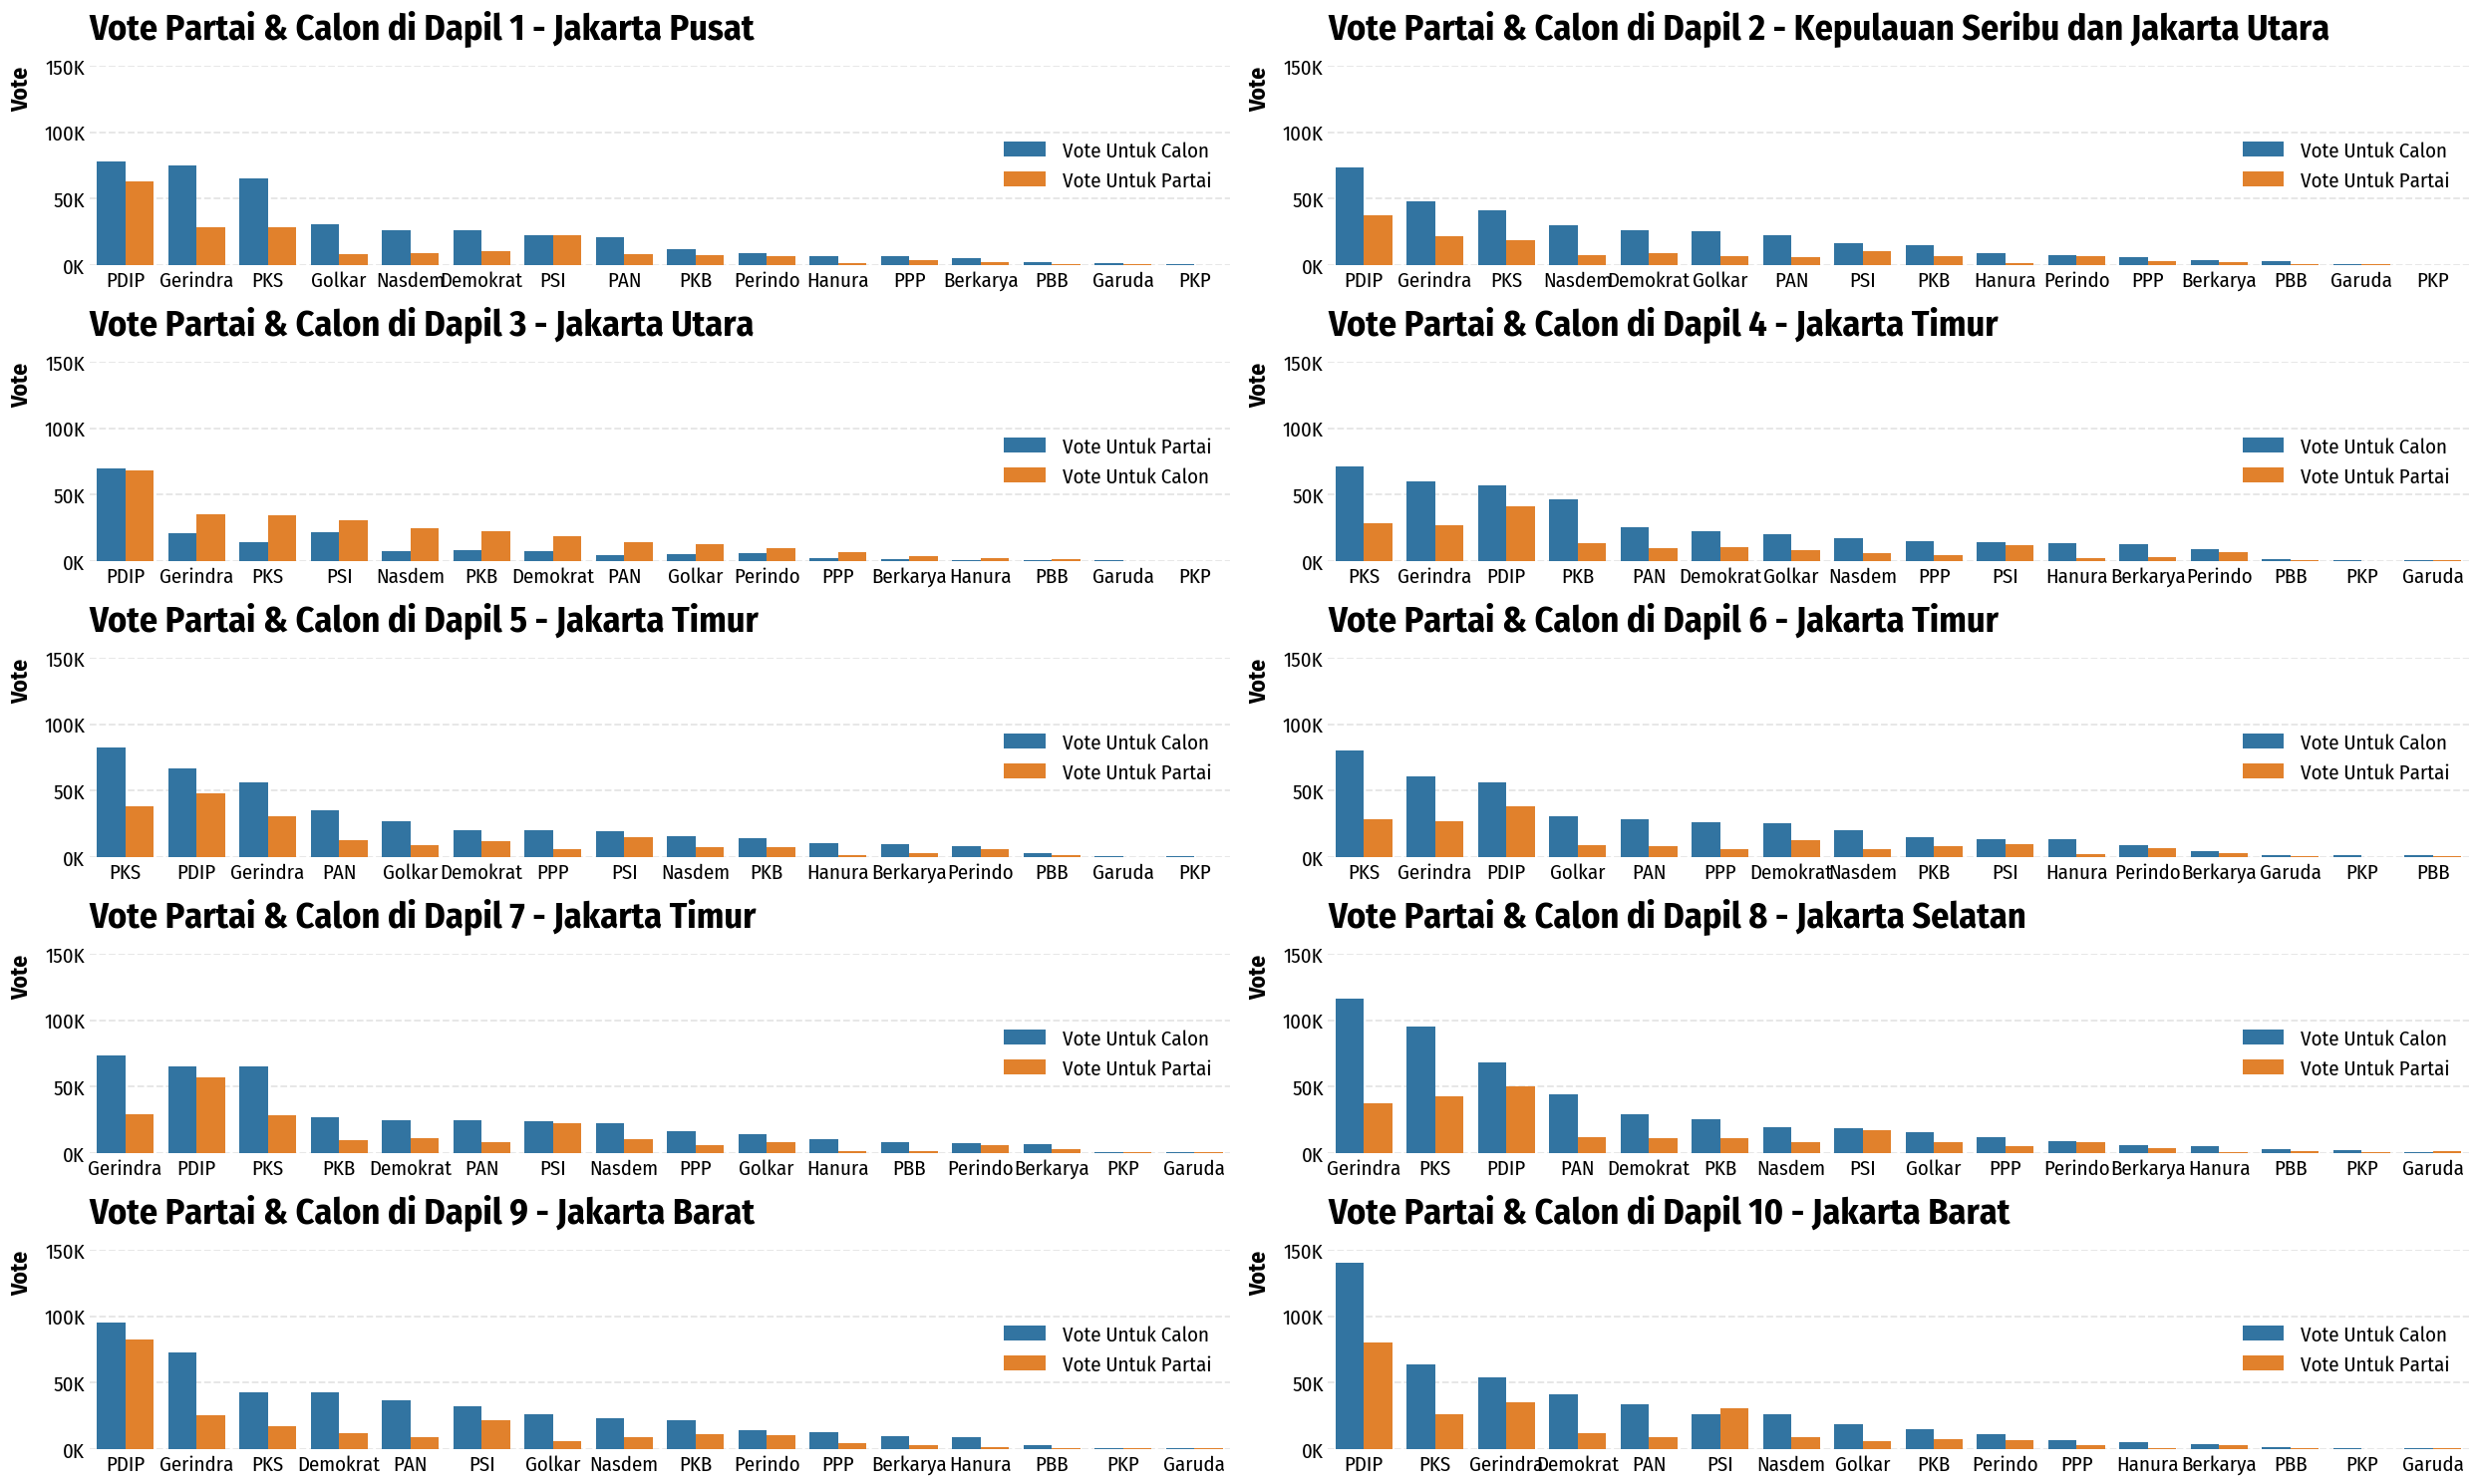

In [1304]:
data = (df
    .groupby(["dapil_no", "dapil_nama", "partai"])
    .agg(
        vote_untuk_partai=("partai_vote", "mean"),
        vote_untuk_calon=("vote", "sum"),
    )
    .reset_index()
    .melt(id_vars=["dapil_no", "dapil_nama", "partai"])
    .assign(
        variable=lambda df_: df_["variable"].str.replace("_", " ").str.title()
    )
)

fig = plt.figure(figsize=(25, 15))
for i in range(1, 11, 1):
    ax = plt.subplot(5, 2, i)
    data_per_dapil = data.loc[data['dapil_no'] == i].sort_values("value", ascending=False)
    sns.barplot(
        data=data_per_dapil, 
        x="partai", 
        y="value",
        hue="variable"
    )
    ax.legend(title="")
    ax.set_ylim(0, 150_000)
    ax.set_xlabel("")
    ax.set_ylabel("Vote")
    ax.set_title(f"Vote Partai & Calon di Dapil {i} - {data_per_dapil['dapil_nama'].unique()[0]}", fontweight="bold")
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        if max(data_per_dapil['value']) >= 1000: 
            ylabels = ['{:,.0f}'.format(y) + 'K' for y in ax.get_yticks()/1000]
            ax.set_yticklabels(ylabels)
        else:
            pass

plt.tight_layout()
plt.show()

Dari chart di atas, bisa kita lihat bahwa tidak ada partai yang kuat di semua dapil. Walaupun demikian, top 3 partai di semua dapil selalu terdiri dari PDIP, Gerindra dan PKS. 

# 5. Apakah Nomor Urut Berpengaruh terhadap Terpilihnya Calon?

In [1305]:
(df
    .groupby(['partai', 'no_urut'])
    .agg(jumlah_calon=('no_urut', 'size'))
    .reset_index()
    .pivot(index='partai', columns='no_urut')
)

jumlah_calon                                                       \
no_urut            1     2     3     4     5     6     7     8     9    10   
partai                                                                       
Berkarya         10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
Demokrat         10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
Garuda           10.0  10.0  10.0   9.0   8.0   5.0   3.0   3.0   1.0  1.0   
Gerindra         10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
Golkar           10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
Hanura           10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
Nasdem           10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
PAN              10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
PBB              10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
PDIP             10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
PKB              10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
PKP              10.0  10.0  10.0   9.0   9.0   8.0   6.0   3.0   2.0  2.0   
PKS              10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
PPP              10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
PSI              10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   
Perindo          10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  10.0  8.0   

                    
no_urut    11   12  
partai              
Berkarya  4.0  4.0  
Demokrat  4.0  4.0  
Garuda    NaN  NaN  
Gerindra  4.0  4.0  
Golkar    4.0  4.0  
Hanura    4.0  4.0  
Nasdem    4.0  4.0  
PAN       4.0  4.0  
PBB       4.0  4.0  
PDIP      4.0  4.0  
PKB       4.0  4.0  
PKP       1.0  1.0  
PKS       4.0  4.0  
PPP       4.0  4.0  
PSI       4.0  4.0  
Perindo   4.0  4.0

Tabel di atas merupakan jumlah calon per nomor urut per partai. Bisa kita lihat, semua partai memiliki masing masing 10 calon dengan nomor urut 1-9, 8 calon dengan nomor urut 10, dan 4 calon dengan nomor urut 11-12 (kecuali partai Garuda dan partai PKP yang memiliki jumlah calon yang lebih sedikit).

Karena jumlah calon per nomor urut per partai sama, kita bisa mencari tahu, apakah nomor urut berpengaruh terhadap terpilihnya calon?

In [1306]:
data = (df
    .loc[(df['terpilih'] == 1) & ~(df['partai'].isin(['Garuda', 'PKP'])) & (df['no_urut'] <= 9)]
    .groupby('no_urut')
    .agg(jumlah_calon_terpilih=('no_urut', 'size'))
    .reset_index()
    .assign(persentase_dari_total=lambda df_: (df_['jumlah_calon_terpilih']
                                               .div(df_['jumlah_calon_terpilih'].sum())
                                               .mul(100)
                                               .round(2)
                                               )
    )
    .rename(columns=lambda c: c.replace('_', ' ').title())
    .set_index('No Urut')
)
data

,Jumlah Calon Terpilih,Persentase Dari Total
No Urut,,
1,53,51.96
2,14,13.73
3,4,3.92
4,11,10.78
5,7,6.86
6,1,0.98
7,4,3.92
8,7,6.86
9,1,0.98


Note: tabel diatas hanya memuat nomor urut 1-9 (karena jumlah calon dengan nomor urut 10-12 tidak seimbang) dan tidak memuat calon dari partai Garuda dan PKP (karena jumlah calon dari partai Garuda dan PKP tidak seimbang).

Bisa kita lihat bahwa dari semua calon yang terpilih, 50% adalah calon dengan nomor urut 1. Kemudian, 13% adalah calon dengan nomor urut 2, 10% adalah calon dengan nomor urut 4.

Menariknya, calon dengan nomor urut 3 hanya menyumbang 4%. Padahal nomor urut 3 ada di antara nomor urut 4.

Ada 2 hasil yang kita temukan: 
1. Nomor-nomor kecil terlihat lebih banyak terpilih dibanding nomor nomor besar
2. Nomor 3 merupakan outlier, dalam artian nomor 3 adalah satu-satunya nomor kecil yang persentase nya dibawah 5%.

Dari hasil ini kita mendapat 2 pertanyaan lanjutan: 
1. Apakah nomor-nomor kecil lebih banyak terpilih hanya karena kebetulan?
2. Apakah nomor 3 sedikit terpilih hanya karena kebetulan?

## 1. Apakah nomor-nomor kecil lebih banyak terpilih hanya karena kebetulan?

Untuk menjawab pertanyaan pertama, kita akan melakukan tes statistik. Tes statistik yang akan kita gunakan adalah test chi-squared goodness-of-fit. 

Ini adalah hipotesis kita: 
- Hipotesis Nol (H0): Nomor urut kecil lebih banyak terpilih karena kebetulan.
- Hipotesis Alternatif (H1): Nomor urut kecil lebih banyak terpilih bukan karena kebetulan.

Kemudian, ini adalah hasil yang kita harapkan:
- Bila hasil test (p value) di  atas 0.05, maka secara sederhana kita menganggap hipotesis nol benar.
- Bila hasil test (p value) di bawah 0.05, maka secara sederhana kita menganggap hipotesis alternatif benar.

Referensi: https://en.wikipedia.org/wiki/Goodness_of_fit

In [1307]:
import scipy.stats as stats

observed = data['Jumlah Calon Terpilih'].values
expected = [observed.mean()] * len(observed)

s, p_val = stats.chisquare(f_obs=observed, f_exp=expected)

print(f'hasil test : p value = {p_val: .50f}')

hasil test : p value =  0.00000000000000000000000000000000000729929625476284


Hasil dari tes statistik menunjukkan nilai jauh dibawah 0.05. Karena itu, kita mengambil kesimpulan bahwa nomor urut kecil lebih banyak terpilih bukan karena kebetulan, artinya nomor-nomor kecil lebih mungkin terpilih.